# Joke

In [121]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('grayscale')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

import numpy as np
from vessel_manoeuvring_models.models.vmm_linear import vmm_linear as vmm
from vessel_manoeuvring_models.models.vmm import ModelSimulator

import pandas as pd
import numpy as np
import vessel_manoeuvring_models.prime_system
from vessel_manoeuvring_models.models import brix_coefficients
from vessel_manoeuvring_models.prime_system import PrimeSystem
import os.path
import pytest
from vessel_manoeuvring_models.visualization.plot import track_plot, track_plots

In [122]:
def get_df_ship_parameters(ship_parameters):

    df_ship_parameters = pd.DataFrame(data = ship_parameters, index=['value'])
    ps = PrimeSystem(**ship_parameters)
    df_ship_parameters.loc['prime'] = ps.prime(ship_parameters)

    return df_ship_parameters

def get_df_parameters(df_ship_parameters):

    df_parameters = brix_coefficients.calculate(df_ship_parameters=df_ship_parameters)
    df_parameters['prime'].fillna(0, inplace=True)
    df_parameters.loc['Ydelta','prime'] = 0.001  # Just guessing
    df_parameters.loc['Ndelta','prime'] = -0.5*df_parameters.loc['Ydelta','prime']  # Just guessing

    return df_parameters




In [123]:
ships_raw = {

    "Titanic" : {
        'T' : 10.5,
        'L' : 269.1,
        'B' : 28.2,
        'volume':52310,
    },
    
    "Santa Maria" : {
        'T' : 4,
        'L' : 36,
        'B' : 7,
    },
    "Jahre Viking" : {
    
        "L": 458.45,
        "B": 68.6,
        "T": 24.6,
        "volume": 646642,
    
    },

}

In [124]:
ship_speeds = {
    
    'Titanic' : 20.1,
    'Santa Maria' : 8,
    'Jahre Viking': 16.5,
    

}

In [125]:
def generate_ship_data(ship_raw: dict):
    
    ship = ship_raw.copy()
    rho_ = ship.get('rho',1025)
    if not 'CB' in ship:
         ship['CB'] = ship.get('CB', 0.6)
            
    if not 'volume' in ship:
        T_ = ship['T']
        B_ = ship['B']
        L_ = ship['L']
        ship['volume'] = L_*B_*T_*ship['CB']
    
    if not 'm' in ship:
        T_ = ship['T']
        B_ = ship['B']
        L_ = ship['L']
        CB_ = ship['CB']
        volume_ = T_*B_*L_*CB_
        m_ = volume_*rho_
        ship['m'] = m_
            
    if not 'I_z' in ship:
        m_ = ship['m']
        L_ = ship['L']
        ship['I_z'] = 0.2*m_*L_**2
    
    if not 'x_G' in ship:
        ship['x_G'] = 0
    
    ship['rho'] = rho_
    
    
    return ship

In [126]:
def generate_hydrodynamic_derivatives(ship_parameters: dict):
    df_ship_parameters = get_df_ship_parameters(ship_parameters=ship_parameters)
    df_parameters = get_df_parameters(df_ship_parameters=df_ship_parameters)
    return df_parameters

In [127]:
ship_datas = {key:generate_ship_data(value) for key,value in ships_raw.items()}
prime_systems = {key:PrimeSystem(**ship_parameters) for key, ship_parameters in ship_datas.items()}
hydrodynamics_derivatives_ships = {key:generate_hydrodynamic_derivatives(ship_parameters) for key, ship_parameters in ship_datas.items()}

In [128]:
def test_model_simulator(vmm, ship_parameters, df_parameters, prime_system, speed):

    ## Define a model simulator:
    # This is a simulator with freezed parameters and ship_parameters:
    parameters = df_parameters['prime']
    model = ModelSimulator(simulator=vmm, 
                           parameters=parameters, 
                           ship_parameters=ship_parameters, 
                           control_keys=['delta'], 
                           primed_parameters=True, 
                           prime_system=prime_system)


    t = np.linspace(0,45,1000)
    df_ = pd.DataFrame(index=t)
    df_['u'] = speed*1.852/3.6
    df_['v'] = 0
    df_['r'] = 0
    df_['x0' ] = 0
    df_['y0' ] = 0
    df_['psi'] = 0
    df_['delta'] = np.deg2rad(35)
    df_['U'] = np.sqrt(df_['u']**2 + df_['v']**2)

    result = model.simulate(df_=df_)
    return result

In [129]:
results = {}
for key, ship_parameters in ship_datas.items():
    df_parameters = hydrodynamics_derivatives_ships[key]
    prime_system = prime_systems[key]
    speed = ship_speeds[key]
    results[key] = test_model_simulator(vmm=vmm, ship_parameters=ship_parameters, df_parameters=df_parameters, prime_system=prime_system, speed=speed).result.copy()

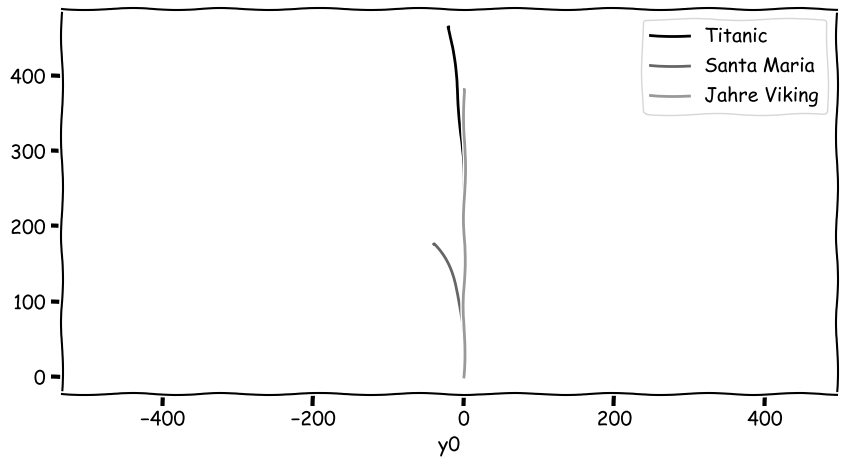

In [130]:
with plt.xkcd(randomness=0.5):
    # This figure will be in XKCD-style
    fig,ax = plt.subplots()
    
    for key, result in results.items(): 
        result.plot(x='y0', y='x0', ax=ax, label=f"{key}")
    ax.axis('equal')
    
    

In [131]:
def plot_iceberg(ax, x0,y0, size=100, **kwargs):
    
    np.random.seed(1)
    
    N=20
    psi = np.linspace(0,2*np.pi, N)
    
    amplitude = np.random.normal(loc=size,scale=0.1*size, size=N)
    xs = amplitude*np.cos(psi)
    ys = amplitude*np.sin(psi)
        
    ax.plot(x0+xs, y0+ys,**kwargs)
    

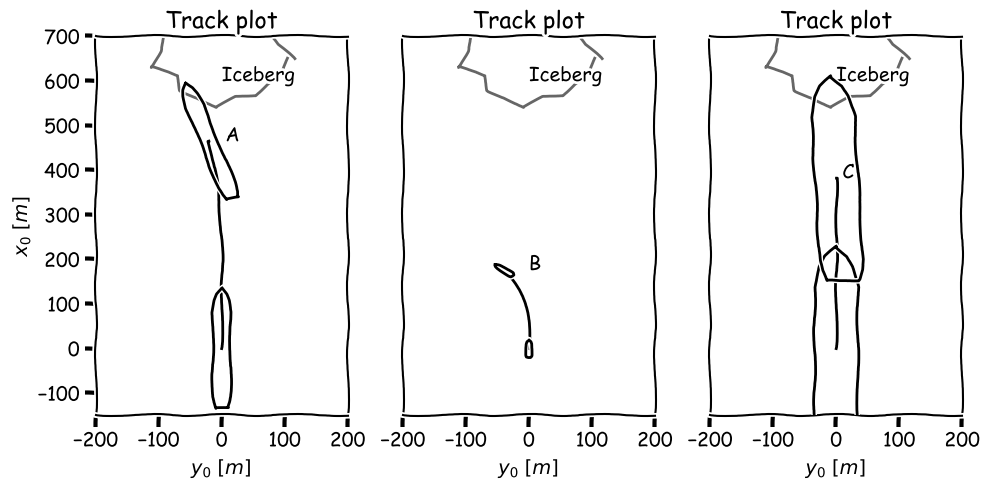

In [155]:
with plt.xkcd(randomness=0.25):
    # This figure will be in XKCD-style
    
    fig,axes=plt.subplots(ncols=len(results))
    axes = {key:ax for key,ax in zip(results.keys(),axes)}
    
    for i,(key, result) in enumerate(results.items()):
        ax = axes[key]
        track_plot(df=results[key], lpp=ship_datas[key]['L'], beam=ship_datas[key]['B'] ,label=f"{key}", N=2, ax=ax, start_color='darkgrey', stop_color='darkgrey', alpha=1, outline=True)
        ax.legend().set_visible(False)
        
        ax.text(0, 600, "Iceberg")
        plot_iceberg(ax=ax, x0=0, y0=650, size=100)
        
        ax.text(results[key]['y0'].mean(), results[key]['x0'].iloc[-1], f" {chr(i+97).upper()}")
        ax.set_aspect('auto')
          
       


    
for ax in axes.values():
    ax.set_xlim((-200,200))
    ax.set_ylim((-150, 700))
    
for ax in list(axes.values())[1:]:
    ax.set_yticks([])
    ax.set_ylabel('')
plt.tight_layout()

fig.savefig("strip_1.pdf")

In [133]:
tuple(np.array(ax.get_xlim())/2)

(-100.0, 100.0)

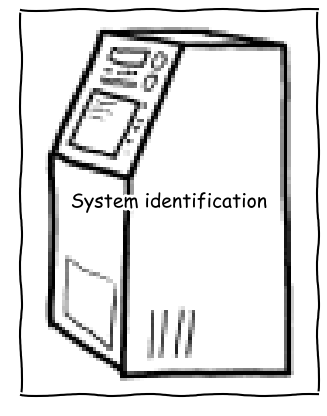

In [156]:
im = plt.imread("ai_research.png")
with plt.xkcd(randomness=0.25):
    implot = plt.imshow(im)
    ax = implot.axes
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(np.array(ax.get_xlim()).mean(),np.array(list(ax.get_ylim())).mean(),"System identification", horizontalalignment='center',
        verticalalignment='center',)
    
plt.savefig("strip_2.pdf")

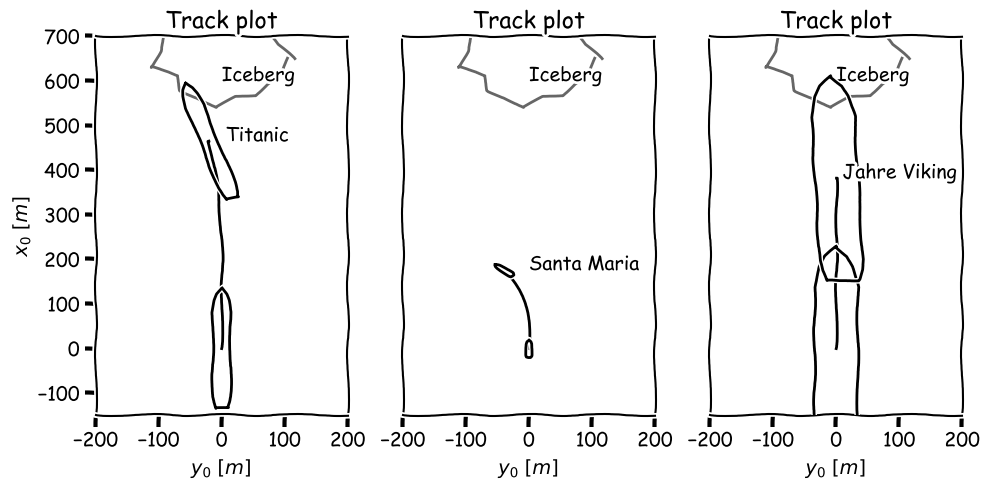

In [157]:
with plt.xkcd(randomness=0.25):
    # This figure will be in XKCD-style
    
    fig,axes=plt.subplots(ncols=len(results))
    axes = {key:ax for key,ax in zip(results.keys(),axes)}
    
    for i,(key, result) in enumerate(results.items()):
        ax = axes[key]
        track_plot(df=results[key], lpp=ship_datas[key]['L'], beam=ship_datas[key]['B'] ,label=f"{key}", N=2, ax=ax, start_color='darkgrey', stop_color='darkgrey', alpha=1, outline=True)
        ax.legend().set_visible(False)
        
        ax.text(0, 600, "Iceberg")
        plot_iceberg(ax=ax, x0=0, y0=650, size=100)
        
        ax.text(results[key]['y0'].mean(), results[key]['x0'].iloc[-1], f" {key}", zorder=20)
        ax.set_aspect('auto')
    
for ax in axes.values():
    ax.set_xlim((-200,200))
    ax.set_ylim((-150, 700))
    
for ax in list(axes.values())[1:]:
    ax.set_yticks([])
    ax.set_ylabel('')
plt.tight_layout()
fig.savefig("strip_3.pdf")